Task 2 — Step 1: Prepare Data for Modeling

In [2]:
import pandas as pd

# Load the clean dataset
data = pd.read_csv('../data/processed/task1_clean_data.csv', parse_dates=['Date'], index_col='Date')

# Select Tesla prices for modeling
tsla_prices = data['TSLA_price']

# Split chronologically
train = tsla_prices[:'2024-12-31']
test = tsla_prices['2025-01-01':]


Step 2 — Implement ARIMA/SARIMA Model

Find ARIMA parameters (p, d, q)

Option 1: Use auto_arima (simplest)

In [3]:
from pmdarima import auto_arima

# Automatically find best (p, d, q)
model_auto = auto_arima(
    train,
    seasonal=False,  # SARIMA = True if seasonality exists
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16368.535, Time=1.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16363.051, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16364.936, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16364.938, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16362.591, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16366.936, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.548 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2515
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8180.296
Date:                Wed, 28 Jan 2026   AIC                          16362.591
Time:                        18:54:44   BIC                          16368.421
Sample:                             0   HQIC                         16364.707
    

Option 2: Manual (using ACF & PACF plots)

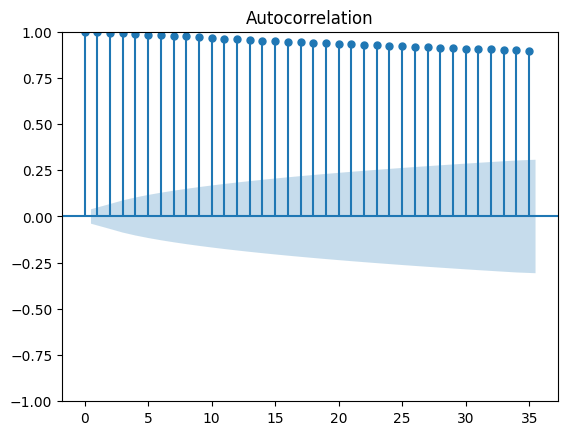

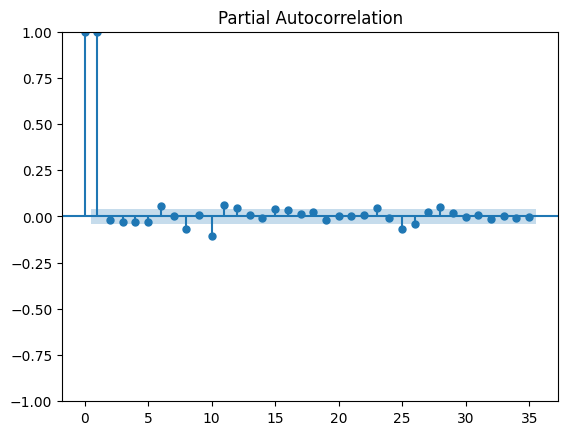

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(train)
plt.show()

plot_pacf(train)
plt.show()


2️⃣ Seasonal SARIMA (Optional)

In [5]:
# Example: monthly seasonality (m=12)
model_sarima = auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=16361.140, Time=6.98 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=16363.051, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=16365.608, Time=0.79 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=16365.849, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=16362.591, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=16369.520, Time=5.15 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=16369.287, Time=5.40 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=16343.014, Time=20.00 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=16341.160, Time=12.80 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=16341.028, Time=8.82 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=16368.287, Time=3.02 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=16342.836, Time=10.55 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=16360.027, Time=3.39 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=16340.038, Time=3.23 sec
 A

3️⃣ Fit ARIMA Model

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Example: using best parameters from auto_arima
best_order = model_auto.order  # (p, d, q)
arima_model = ARIMA(train, order=best_order)
arima_result = arima_model.fit()

print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:             TSLA_price   No. Observations:                 2515
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -8180.296
Date:                Wed, 28 Jan 2026   AIC                          16362.591
Time:                        18:58:16   BIC                          16368.421
Sample:                             0   HQIC                         16364.707
                               - 2515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        39.2492      0.442     88.822      0.000      38.383      40.115
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):             11674.77
Prob(Q):                              0.73   Pr

e:\Time-Series-Forecasting-for-Portfolio-Management-Optimization-week-9\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Time-Series-Forecasting-for-Portfolio-Management-Optimization-week-9\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Time-Series-Forecasting-for-Portfolio-Management-Optimization-week-9\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


4️⃣ Generate Forecasts

e:\Time-Series-Forecasting-for-Portfolio-Management-Optimization-week-9\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\Time-Series-Forecasting-for-Portfolio-Management-Optimization-week-9\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


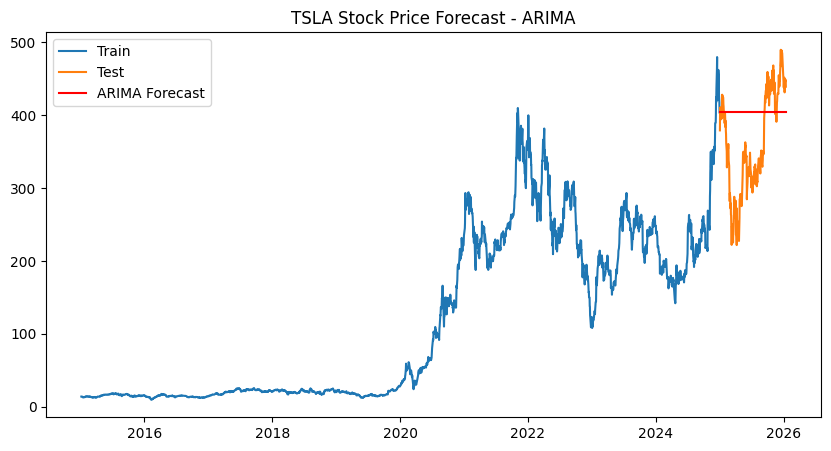

In [7]:
# Forecast length = length of test set
forecast = arima_result.forecast(steps=len(test))

# Compare actual vs forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title("TSLA Stock Price Forecast - ARIMA")
plt.show()


5️⃣ Evaluate Performance

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 69.50
RMSE: 82.93


Task 2b — LSTM Modeling for TSLA

1️⃣ Prepare Sequence Data

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Use TSLA prices (or returns)
tsla_series = data['TSLA_price'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
tsla_scaled = scaler.fit_transform(tsla_series)

# Split train/test (chronologically)
train_scaled = tsla_scaled[:len(train)]
test_scaled = tsla_scaled[len(train):]

# Function to create sequences
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, window=60)
X_test, y_test = create_sequences(test_scaled, window=60)

# Reshape for LSTM input [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


2️⃣ Build LSTM Architecture

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1))  # Predict next day

# Compile
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50


e:\Time-Series-Forecasting-for-Portfolio-Management-Optimization-week-9\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0097 - val_loss: 0.0029
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.1472e-04 - val_loss: 0.0022
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.4280e-04 - val_loss: 0.0018
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.6902e-04 - val_loss: 0.0023
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.4280e-04 - val_loss: 0.0018
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.7509e-04 - val_loss: 0.0026
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.8423e-04 - val_loss: 0.0014
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.0516e-04 - val_loss: 0.0015
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.9665e-04 - val_loss: 0.0013
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.7098e-04 - val_loss: 0.0012
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.4705e-04 - val_loss: 0.0011
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━

3️⃣ Generate Forecasts

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


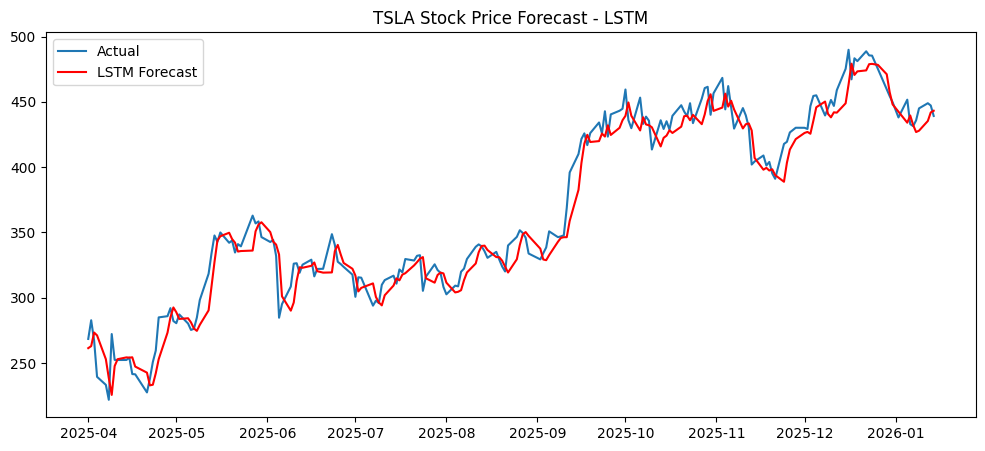

In [12]:
y_pred_scaled = lstm_model.predict(X_test)
# Inverse scaling to get original price
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test.index[60:], y_true, label='Actual')
plt.plot(test.index[60:], y_pred, label='LSTM Forecast', color='red')
plt.title("TSLA Stock Price Forecast - LSTM")
plt.legend()
plt.show()


4️⃣ Evaluate LSTM Forecasts

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"LSTM MAE: {mae:.2f}")
print(f"LSTM RMSE: {rmse:.2f}")
print(f"LSTM MAPE: {mape:.2f}%")


5️⃣ Compare with ARIMA